### 사전 학습된 CNN 모형 사용 (Transfer Learning).

In [1]:
# !pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings           
import random
import cv2
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data                           
from tensorflow.keras.models import Model                       # Functional API 사용 예정.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.datasets.cifar10 import load_data                           
from tensorflow.keras.applications import mobilenet             # 비교적 작은 크기의 모형.
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')                               # Turn the warnings off.
%matplotlib inline

In [3]:
# # GPU를 검출해서 메모리 확장을 허락할 필요가 있다.
# my_gpus = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(my_gpus[0],True)

#### 1. 데이터 불러오기:

자세한 설명은 [이곳](https://www.cs.toronto.edu/~kriz/cifar.html)을 참고한다.

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# 데이터 가져오기.
(X_train_raw, y_train), (X_test_raw, y_test) = load_data()
print("최대 픽셀값:",X_train_raw.max())
print("최소 픽셀값:",X_train_raw.min())

최대 픽셀값: 255
최소 픽셀값: 0


In [6]:
# 유형별 이름 사전.
name_dict = {0:"Airplane", 1:"Automobile", 2:"Bird", 3:"Cat", 4:"Deer", 5:"Dog", 6:"Frog", 7:"Horse", 8:"Ship", 9:"Truck"}

#### 2. 데이터 전처리:

#### 2.1. 리사이징:

In [7]:
# 원본의 1/10 가량만 사용하도록 한다.
n_train_size = 5000
n_test_size  = 1000

# X_train 리사이징.
print("-"*20)
print("X_train 리사이징.")
for i in range(n_train_size):
    if ( (i + 1) % 1000) == 0:
        print(f"Step : {i+1}")
    if i == 0:
        X_train = np.expand_dims(cv2.resize(X_train_raw[i,:,:,:],dsize=(128,128)),axis=0)
    else:
        X_train = np.concatenate([X_train,np.expand_dims(cv2.resize(X_train_raw[i,:,:,:],dsize=(128,128)),axis=0)], axis=0)

# X_test 리사이징.
print()
print("-"*20)
print("X_test 리사이징.")
for i in range(n_test_size):
    if ( (i + 1) % 1000) == 0:
        print(f"Step : {i+1}")
    if i == 0:
        X_test = np.expand_dims(cv2.resize(X_test_raw[i,:,:,:],dsize=(128,128)),axis=0)
    else:
        X_test = np.concatenate([X_test,np.expand_dims(cv2.resize(X_test_raw[i,:,:,:],dsize=(128,128)),axis=0)], axis=0)
print("-"*20)

--------------------
X_train 리사이징.
Step : 1000
Step : 2000
Step : 3000
Step : 4000
Step : 5000

--------------------
X_test 리사이징.
Step : 1000
--------------------


In [8]:
print("최대 픽셀값:",X_train.max())
print("최소 픽셀값:",X_train.min())

최대 픽셀값: 255
최소 픽셀값: 0


#### 2.2. One-Hot-Encoding:

In [9]:
# y 변수 간추리기와 one-hot-encoding.
y = np.concatenate([y_train[:n_train_size],y_test[:n_test_size]],axis=0)   # 간추리고 이어 붙이기.
y = to_categorical(y,10)
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

In [10]:
# Shape 확인.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (5000, 128, 128, 3)
Training data y shape: (5000, 10)
--------------------------------------------------
Test data X shape: (1000, 128, 128, 3)
Test data y shape: (1000, 10)
--------------------------------------------------


#### 3. 사전 학습된 CNN 모델을 가져와서 살펴본다.

In [11]:
# MobileNet을 가져와 본다.
# 입력 크기는 128, 160, 192, 224 가 가능하다.
my_mnet = mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(128,128,3))       # include_top = False에 주목한다!

17225924/17225924 [==============================] - 1s 0us/step


In [12]:
# 중요: trainable  = False 이면 사전 학습된 가중치는 "동결" 상태로 유지된다!!!
my_mnet.trainable = False

In [13]:
# 가져온 모델의 summary (내부 구조) 출력.
my_mnet.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 8, 8, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 8, 8, 512)         262144    
                                                                 
 conv_pw_9

#### 4. 최종 모델을 만든다.

In [14]:
drop_prob = 0.5
# PART 1: 입력 부분에 전처리 layer를 삽입한다.
my_input = Input([128, 128, 3], dtype = tf.float32, name="Input")       
x = mobilenet.preprocess_input(my_input)
# PART 2: Convolution 파트를 추가한다. 
x = my_mnet(x)      
# PART #: Classification을 위한 나머지 layer구조를 추가한다.
x = Flatten(name="Flatten")(x)
x = Dense(units = 1024, activation="relu", name="Dense1")(x)  
# Dropout 적용.
x = Dropout(rate=drop_prob, name="Dropout")(x)
# Fully connected layer 추가.
x = Dense(units = 256, activation="relu", name="Dense2")(x)            
# 출력층. 
x = Dense(units = 10, activation="softmax", name="Dense3-Output")(x)             # 10가지 유형이 있다.
# Functional API를 사용하여 최종 모델을 만든다.
my_model = Model(inputs=my_input, outputs=x)   

In [15]:
# 전체 모델의 summary (내부 구조) 출력.
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 Flatten (Flatten)           (None, 16384)             0         
                                                             

#### 5. Hyperparameter 와 Optimizer 정의:

In [16]:
# Hyperparameters.
n_epochs = 20
batch_size = 36
learn_rate = 0.00002

In [17]:
# Optimizer 객체 생성 후 컴파일한다.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 6. 학습 & History 시각화:

In [18]:
# 학습.
# verbose = 0 : 출력 없음. verbose = 1 : 출력 함.
my_EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)          # 조기 종료 허락!
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split = 0.3, verbose = 1,callbacks=[my_EarlyStop])

Epoch 1/20
98/98 [==============================] - 25s 237ms/step - loss: 2.0305 - accuracy: 0.3849 - val_loss: 0.9116 - val_accuracy: 0.6867
Epoch 2/20
98/98 [==============================] - 22s 226ms/step - loss: 0.9457 - accuracy: 0.6823 - val_loss: 0.7074 - val_accuracy: 0.7547
Epoch 3/20
98/98 [==============================] - 21s 215ms/step - loss: 0.6268 - accuracy: 0.7831 - val_loss: 0.6267 - val_accuracy: 0.7833
Epoch 4/20
98/98 [==============================] - 22s 222ms/step - loss: 0.4638 - accuracy: 0.8420 - val_loss: 0.5937 - val_accuracy: 0.7887
Epoch 5/20
98/98 [==============================] - 21s 219ms/step - loss: 0.3270 - accuracy: 0.8903 - val_loss: 0.5735 - val_accuracy: 0.8000
Epoch 6/20
98/98 [==============================] - 21s 214ms/step - loss: 0.2571 - accuracy: 0.9191 - val_loss: 0.5417 - val_accuracy: 0.8100
Epoch 7/20
98/98 [==============================] - 21s 213ms/step - loss: 0.1832 - accuracy: 0.9443 - val_loss: 0.5386 - val_accuracy: 0.8153

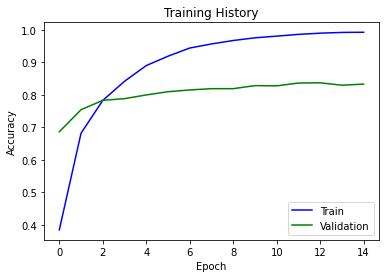

In [19]:
# Visualize the training history. 
n_skip = 0                 # Skip the first few steps.
plt.plot(my_summary.history['accuracy'][n_skip:], c="b")
plt.plot(my_summary.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 7. 테스팅: 

정답 : Deer
1/1 [==============================] - 0s 358ms/step
예측 : Deer


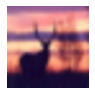

정답 : Ship
1/1 [==============================] - 0s 24ms/step
예측 : Ship


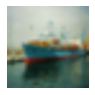

정답 : Cat
1/1 [==============================] - 0s 23ms/step
예측 : Cat


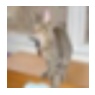

정답 : Frog
1/1 [==============================] - 0s 24ms/step
예측 : Frog


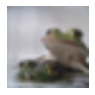

정답 : Horse
1/1 [==============================] - 0s 23ms/step
예측 : Horse


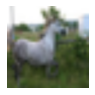

In [20]:
# 랜덤으로 테스트 이미지를 추출해서 예측해 본다.
for i_image in [ random.randint(0,n_test_size-1) for _ in range(5)]:
    print("정답 :" , name_dict[np.argmax(y_test[i_image])])
    print("예측 :" , name_dict[np.argmax(my_model.predict(X_test[i_image].reshape(1,128,128,3)))])  # 먼저 4 차원 배열로 reshaping 해준다!!!
    plt.figure(figsize=(1.5,1.5))
    plt.imshow(X_test[i_image])
    plt.axis("off")
    plt.show()

In [21]:
# 최종적으로 정확도 계산.
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.828


**NOTE**: 이전에 직접 만든 모델보다 성능이 월등히 좋다!